# 🚜 Predicting the Sale Prices of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for? 

## 2. Data

The data has been downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project, check out: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on the Kaggle website: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

In [22]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns

In [23]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False)

### Exploratory Data Analysis (EDA)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [25]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [26]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

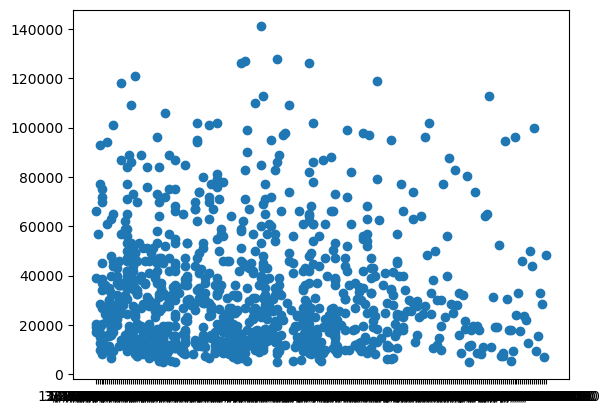

In [27]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

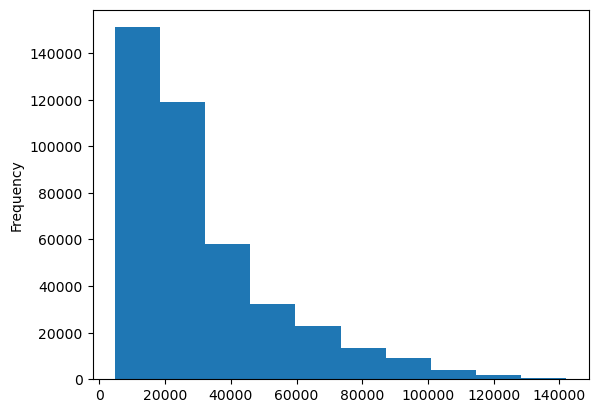

In [28]:
df.SalePrice.plot.hist();

#### Parsing Dates

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling pandas which of our columns have dates in them using the 'parse_dates' parameter.

In [29]:
# Import the data again, but this time using parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False,
                parse_dates=["saledate"])

In [30]:
df.saledate.dtype

dtype('<M8[ns]')

In [17]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

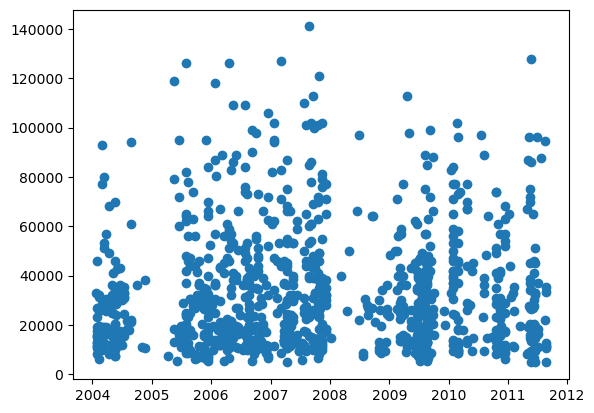

In [31]:
# Plot data points again
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

In [32]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [27]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

#### Sort DataFrame by saledate

**Note:** When working with time series data, it's a good idea to sort it by date.

In [33]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [34]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

#### Make a copy of original DataFrame

We make a copy of the original dataframe so that when we manipulate the copy, we still got our original data.

In [35]:
# Make a copy
df_tmp = df.copy()
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

#### Feature Engineering

##### Add date-time parameters for `saledate` column

In [36]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year

In [37]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int32

In [38]:
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [47]:
df_tmp.head(20).T

,205615,233186,142491,115536,92301,115892,134080,92294,31494,140922,66337,92531,82122,92256,145670,92780,238373,127132,115102,32317
SalesID,1646770,1728883,1508502,1452578,1403418,1453054,1491298,1403411,1263797,1504404,1338469,1403696,1380692,1403368,1515985,1403992,1740272,1475043,1452025,1265202
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0,36000.0,46000.0,23000.0,17000.0,26000.0,50000.0,23500.0,79000.0,21500.0,16000.0,26250.0,10000.0,18500.0,17500.0,21000.0
MachineID,1126363,1523610,1153157,1544443,1390168,1117184,1322436,1184544,1526902,1310407,1505032,888616,1269911,1165291,1078132,561595,1090529,1420590,1145615,1385055
ModelID,8434,9105,4138,3854,7110,3854,4107,7110,6953,4139,23944,7110,4128,7110,3369,7110,8988,7277,3854,6788
datasource,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,18.0,99.0,99.0,99.0
YearMade,1974,1986,1972,1974,1986,1977,1987,1986,1983,1975,1984,1986,1986,1985,1967,1986,1979,1968,1971,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [39]:
# Now that we've enriched our DataFrame with date-time features, we can remove the `saledate` feature
df_tmp.drop(["saledate"], axis=1, inplace=True)

In [40]:
# Check values for different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We've done enough EDA (we can always do more) but we can start modelling our data.

In [54]:
# Let's build a machine learning model!
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1,
#                             random_state=42)

# model.fit(df_tmp.drop(["SalePrice"], axis=1), df_tmp.SalePrice)

The above code leads to an error because we have non-numeric values and NA for our inputs that won't work to fit for out output variable.

### Convert Strings to Categories

One way we can convert all of our data into numbers is to convert them into pandas categories.

We can check the different data types compatible with pandas here: https://pandas.pydata.org/docs/reference/api/pandas.api.types.union_categoricals.html

In [55]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,WA150,D7F,966C,416


In [60]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [10]:
df_tmp.UsageBand = df_tmp.UsageBand.astype(str)

In [11]:
# Find columns which contains strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [62]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 412698 non-null  object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [12]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [65]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 412698 non-null  category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [66]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [67]:
# Pandas has assigned numerical values to the category columns. We can see the codes here.
df_tmp.state.cat.codes

205615    43
233186     8
142491     8
115536     8
92301      8
          ..
409901     4
405777     4
411889     4
411890     4
409203     4
Length: 412698, dtype: int8

In [88]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [89]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
             index=False)

In [41]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
             low_memory=False)

### Dealing with missing values

In [94]:
# First, let's handle numeric missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [101]:
# Check to see which numeric columns have null values in them
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [42]:
# Fill the numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column to indicate if data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median()) 

In [43]:
# Check to see if there are any more numeric missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [119]:
# Check to see how many examples were missing
df_tmp["MachineHoursCurrentMeter_is_missing"].value_counts()

MachineHoursCurrentMeter is missing
True     265194
False    147504
Name: count, dtype: int64

In [120]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [123]:
# Check for columns that aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [124]:
pd.Categorical(df_tmp.state).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [44]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate if sample has missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # turn categories into numbers and add +1 (to avoid having -1 in dataset since null vals are -1)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [45]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [133]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [140]:
df_tmp.drop("MachineHoursCurrentMeter is missing_is_missing", axis=1, inplace=True)

In [143]:
df_tmp.isna().sum()[:60]

SalesID                                0
SalePrice                              0
MachineID                              0
ModelID                                0
datasource                             0
auctioneerID                           0
YearMade                               0
MachineHoursCurrentMeter               0
UsageBand                              0
fiModelDesc                            0
fiBaseModel                            0
fiSecondaryDesc                        0
fiModelSeries                          0
fiModelDescriptor                      0
ProductSize                            0
fiProductClassDesc                     0
state                                  0
ProductGroup                           0
ProductGroupDesc                       0
Drive_System                           0
Enclosure                              0
Forks                                  0
Pad_Type                               0
Ride_Control                           0
Stick           

In [144]:
df_tmp.rename(columns={"auctioneerID is missing": "auctioneerID_is_missing",
                      "MachineHoursCurrentMeter is missing":"MachineHoursCurrentMeter_is_missing"},
             inplace=True)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


Now that our dataframe is all numeric and we have no missing values, we should be able to build a machine learning model.

In [46]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
2,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
3,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
4,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [48]:
%%time
# Instantiate model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

#Fit the data to the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: user 12min 27s, sys: 3.62 s, total: 12min 30s
Wall time: 1min 40s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [49]:
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875966080326709

**Question:** Why doesn't the above metric hold water?

**Answer:** Because we tested it on the same data it was trained one.

### Splitting Data into Train/Validation sets

In [14]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [50]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [51]:
# Split data int X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [52]:
y_train

0          9500.0
1         30000.0
2         21000.0
3         33000.0
4         24000.0
           ...   
401120    34500.0
401121    19000.0
401122    24000.0
401123    18000.0
401124    24000.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

In [53]:
# Create evaluation (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Validation MEA": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Validation RSMLE": rmsle(y_valid, val_preds),
             "Training R^2": r2_score(y_train, train_preds),
             "Validation R^2": r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune hyperparameters and save computing time)

In [54]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples=10000)

In [55]:
%%time
# Cutting down on max samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 26.5 s, sys: 358 ms, total: 26.9 s
Wall time: 4.2 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [56]:
show_scores(model)

{'Training MAE': 5548.995840324089,
 'Validation MEA': 7179.6961392897265,
 'Training RMSLE': 0.25737726780537257,
 'Validation RSMLE': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'Validation R^2': 0.8320179198265638}

### Hyperparameter tuning with RandomizedSearchCV

In [58]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different Random Forest hyperparameters
rs_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

# Instantiate Randomized Search model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rs_grid,
                             n_iter=3,
                             cv=5,
                             verbose=True)

# Fit the Randomized Search CV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 14.3 s, sys: 1.28 s, total: 15.6 s
Wall time: 14.7 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=3,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [59]:
 rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [60]:
# Evaluate Randomized Search model
show_scores(rs_model)

{'Training MAE': 6087.622633064272,
 'Validation MEA': 7434.032834454891,
 'Training RMSLE': 0.2769824820080678,
 'Validation RSMLE': 0.3022876168117713,
 'Training R^2': 0.8346927492755489,
 'Validation R^2': 0.818956909772677}

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [61]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None,
                                   random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 2min 7s, sys: 556 ms, total: 2min 7s
Wall time: 17.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [62]:
# Scores on ideal model, trained on all the data
show_scores(ideal_model)

{'Training MAE': 2956.4887000110048,
 'Validation MEA': 5957.457704159022,
 'Training RMSLE': 0.14448478225577732,
 'Validation RSMLE': 0.24544663828024388,
 'Training R^2': 0.9587936671021189,
 'Validation R^2': 0.8820814857765893}

In [63]:
# Scores on rs_model, trained on ~10,000 examples
show_scores(rs_model)

{'Training MAE': 6087.622633064272,
 'Validation MEA': 7434.032834454891,
 'Training RMSLE': 0.2769824820080678,
 'Validation RSMLE': 0.3022876168117713,
 'Training R^2': 0.8346927492755489,
 'Validation R^2': 0.818956909772677}

### Make predictions on test data

In [64]:
# Import test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [194]:
# Make predictions on the test dataset
# test_preds = ideal_model.predict(df_test)

**Question:** Why might the above code NOT work?

**Answer:** Because the test data hasn't been preprocessed yet in the same format as the training data was.

### Preprocessing the test data

In [65]:
def preprocess_data(df):
    """
    Performs transformations on df and returns preprocessed df
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear

    df.drop("saledate", axis=1, inplace=True)

    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column to indicate if data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median()) 

        # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate if sample has missing value
            df[label+"_is_missing"] = pd.isnull(content)
            # turn categories into numbers and add +1 (to avoid having -1 in dataset since null vals are -1)
            df[label] = pd.Categorical(content).codes + 1

    return df

In [66]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


**Note:** Training data set has 102 columns, so an error will raise if we try to use predictions

In [67]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [69]:
# Manually adjust df_test to have `auctioneerID_is_missing` column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


**Finally, our test dataframe has the same features as our train dataframe, so we can make predictions!**

In [70]:
# Column order matters for predictions (this adjustment had to happen before I could predict)
df_test.columns = X_train.columns

In [71]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [72]:
test_preds

array([20844.479745  , 19621.34691432, 47575.88044609, ...,
       15421.82816939, 20250.16687926, 30332.40090461])

In [73]:
len(test_preds)

12457

### Format predictions into the same format Kaggle wants

In [221]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,18506.839127
1,1227844,21587.508055
2,1227847,47208.208233
3,1227848,60534.786436
4,1227863,49157.589483
...,...,...
12452,6643171,45061.941017
12453,6643173,16063.700245
12454,6643184,14765.016812
12455,6643186,21354.248378


In [222]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**. (SalePrice) 

In [74]:
# Find feature importances of our best model
ideal_model.feature_importances_

array([3.15414823e-02, 1.99479809e-02, 4.54712559e-02, 1.90514307e-03,
       3.40436007e-03, 2.03055338e-01, 3.20937511e-03, 9.80203151e-04,
       4.03804074e-02, 4.09729014e-02, 6.07614597e-02, 4.53352387e-03,
       1.65881480e-02, 1.56632161e-01, 4.51592711e-02, 5.92951020e-03,
       2.17647288e-03, 4.89432486e-03, 3.33540585e-03, 6.05718935e-02,
       5.18390347e-04, 5.14462344e-05, 8.33786888e-04, 1.98674292e-04,
       1.01490464e-03, 2.41532133e-05, 6.14887534e-03, 8.96349014e-03,
       2.67536372e-03, 1.67263555e-04, 5.80998016e-03, 3.68398035e-03,
       4.56685713e-03, 2.99838744e-03, 3.00346844e-04, 4.22237672e-03,
       8.83925334e-04, 1.85417888e-02, 7.58409741e-04, 2.36577120e-03,
       9.38522565e-04, 8.50062978e-04, 2.53147871e-03, 5.92189591e-04,
       5.23013441e-04, 3.64473747e-04, 3.90509324e-04, 1.60955258e-03,
       9.86169971e-04, 2.37251098e-04, 3.03409289e-04, 7.37648620e-02,
       3.77698559e-03, 5.71902807e-03, 2.90512974e-03, 9.83078391e-03,
      

In [83]:
# Helper function for visualizing feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

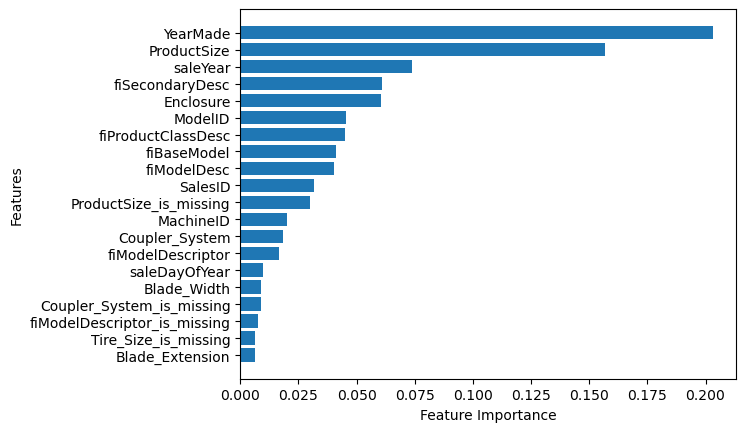

In [84]:
plot_features(X_train.columns, ideal_model.feature_importances_)